In [1]:
import random
import torch
from d2l import torch as d2l

In [2]:
# tokenize对每行进行拆分 返回一个二维列表 第一个维度代表行
tokens = d2l.tokenize(d2l.read_time_machine())
# 将每行的词元整合到一次 然后统计其词频
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
# 打印十个最常用的单词
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

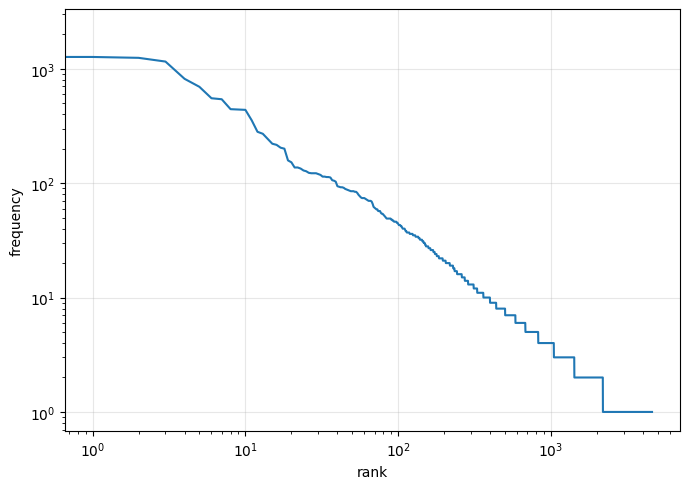

In [3]:
# 获取词频列表
freqs = [freq for token, freq in vocab.token_freqs]

# 使用标准 matplotlib 绘图
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(freqs)
plt.xlabel('rank')
plt.ylabel('frequency')
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# 二元语法词频分析
# corpus[:-1]: 语料库中除最后一个词元外的所有词元
# corpus[1:]: 语料库中除第一个词元外的所有词元
# zip(corpus[:-1], corpus[1:]): 将这两个列表配对，形成连续词元对
# 假设corpus = [1, 2, 3, 4] corpus[:-1] = [1, 2, 3] corpus[1:] = [2, 3, 4]
# zip(corpus[:-1], corpus[1:]) = [(1,2), (2,3), (3,4)]
# 这样可以按照词元的出现顺序捕获相邻的词元对
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]
# 在十个最频繁的词对中，有九个是由两个停用词组成的

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [5]:
# 同上 三元语法词频分析
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

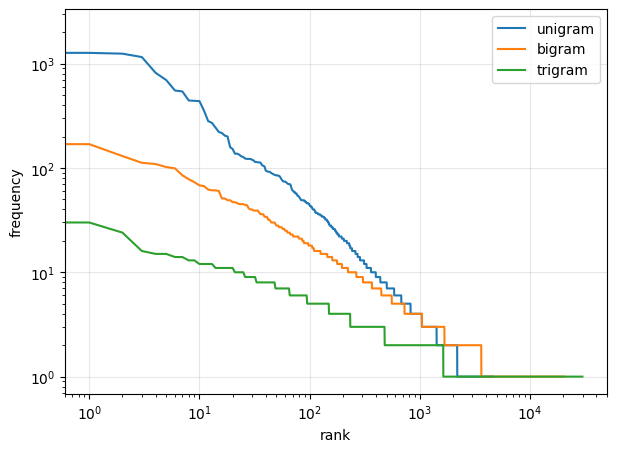

In [6]:
# 获取频率列表
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

# 使用标准matplotlib绘图
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.loglog(freqs, label='unigram')
plt.loglog(bigram_freqs, label='bigram')
plt.loglog(trigram_freqs, label='trigram')

plt.xlabel('rank')
plt.ylabel('frequency')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
# 详细图片见书本
# 由这个 我们知道了 一元语法和单词序列都遵顼齐普夫定律
# n元组的数量并不大
# 很多n元组很少出现

In [7]:
# 使用随机抽样生成一个小批量子序列
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    # corpus是之前生成的语料库
    # 生成了一个随机数 然后用这个随机数进行切片操作 抛弃了前几个
    # 原始语料库：[10, 11, 12, 13, 14, 15, 16, 17, 18, 19] num_steps = 4
    # 如果随机值=0：corpus = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]（保持不变）
    # 如果随机值=1：corpus = [11, 12, 13, 14, 15, 16, 17, 18, 19]（丢弃第一个元素）
    # 如果随机值=2：corpus = [12, 13, 14, 15, 16, 17, 18, 19]（丢弃前两个元素）
    # 如果随机值=3：corpus = [13, 14, 15, 16, 17, 18, 19]（丢弃前三个元素）
    # 这种随机性增强了训练过程中的数据多样性，有助于提高模型泛化能力
    corpus = corpus[random.randint(0, num_steps - 1):]
    # -1是因为标签序列Y序列是X序列向后移动一个位置
    # 整除// num_steps计算可以分割出多少个完整长度为num_steps的序列
    # 语料库 corpus = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]（长度为10） num_steps = 3（每个子序列长度为3）
    # 生成的子序列对可能是：X₁: [0,1,2], Y₁: [1,2,3] X₂: [3,4,5], Y₂: [4,5,6] X₃: [6,7,8], Y₃: [7,8,9]
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    # range(start, stop, step) 创建一个等差数列：
    # start = 0：从语料库的开始位置开始
    # stop = num_subseqs * num_steps：结束于最后一个完整子序列的起始位置
    # step = num_steps：每个索引间隔正好是一个子序列的长度
    # initial_indices = list(range(0, 4 * 5, 5))
    #             = list(range(0, 20, 5))
    #             = [0, 5, 10, 15]
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]
    
    # 计算批次数量 在深度学习训练中，通常要求每个批次的大小完全相同
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # initial_indices包含子序列的随机起始索引
        # 每次从中取batch_size个索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [8]:
# 小测试
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[27, 28, 29, 30, 31],
        [ 2,  3,  4,  5,  6]]) 
Y: tensor([[28, 29, 30, 31, 32],
        [ 3,  4,  5,  6,  7]])
X:  tensor([[17, 18, 19, 20, 21],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[18, 19, 20, 21, 22],
        [23, 24, 25, 26, 27]])
X:  tensor([[ 7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [13, 14, 15, 16, 17]])


In [13]:
# 进行顺序分区
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    # 设置随机偏移量
    offset = random.randint(0, num_steps)
    # 计算总词元数 -1是为了生成标签
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [14]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 0,  1,  2,  3,  4],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 1,  2,  3,  4,  5],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 5,  6,  7,  8,  9],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [23, 24, 25, 26, 27]])
X:  tensor([[10, 11, 12, 13, 14],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [28, 29, 30, 31, 32]])


In [15]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [16]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab